In [161]:
import transformer_lens
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

In [3]:
device_name = "cpu"
if torch.cuda.is_available():
    device_name = "cuda" # CUDA for NVIDIA GPU

device = torch.device(device_name)
print(f"Device: {device_name}")

Device: cuda


In [4]:
# Load a model (eg GPT-2 Small)
model = transformer_lens.HookedTransformer.from_pretrained("gpt2-small")

# Run the model and get logits and activations
logits, activations = model.run_with_cache("Hello World")

Loaded pretrained model gpt2-small into HookedTransformer


## tokens

In [122]:
N_WORDS = 10000
with open('common_words.txt', 'r') as file:
    words = np.random.choice([l.rstrip("\n") for l in file.readlines()], N_WORDS)

words

array(['plain', 'spec', 'things', ..., 'leeds', 'diet', 'containing'],
      dtype='<U22')

In [123]:
word_len_dict = {}
rows = []
for w in words:
    t = len(model.to_tokens(w, prepend_bos=False).squeeze(0))
    t_space = len(model.to_tokens(f" {w}", prepend_bos=False).squeeze(0))
    word_len_dict[w] = t_space
    row = {
        "word": w,
        "n_tokens": t,
        "n_tokens_space": t_space
    }
    rows.append(row)

word_df = pd.DataFrame(rows)
word_df

,word,n_tokens,n_tokens_space
0,plain,1,1
1,spec,1,1
2,things,1,1
3,quebec,3,3
4,consequences,3,1
...,...,...,...
9995,rocket,1,1
9996,systematic,2,1
9997,leeds,2,2
9998,diet,2,1


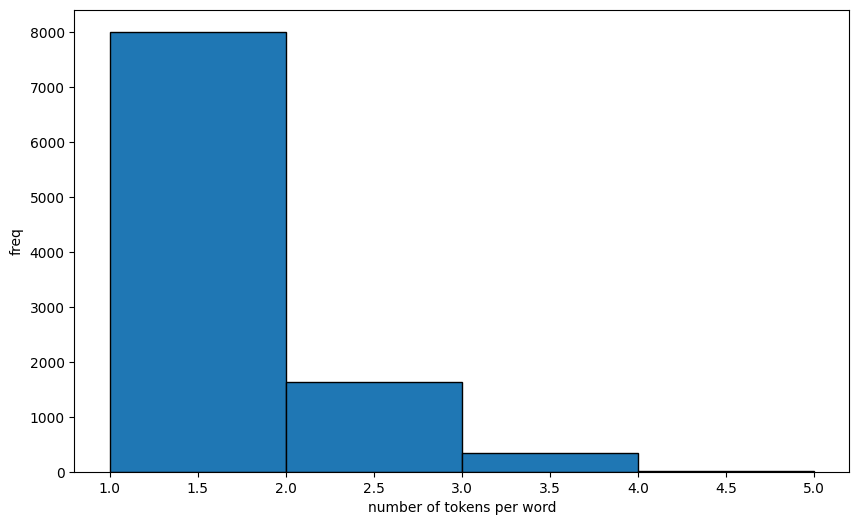

In [124]:
plt.figure(figsize=(10, 6))
plt.hist(word_df['n_tokens_space'], bins=len(word_df['n_tokens_space'].unique())-1, edgecolor='k')
plt.xlabel('number of tokens per word')
plt.ylabel('freq')
plt.show()

## building dataset

In [218]:
word_len = np.vectorize(lambda x: word_len_dict[x])

In [219]:
PREFIX = "Welcome to my blog. "
BATCH_SIZE = 64
N_SAMPLE = 10

prefix_len = len(model.to_tokens(PREFIX, prepend_bos=True).squeeze(0)) - 1

def generate_batch():
    batch_words = []
    for i in range(BATCH_SIZE):
        sampled = np.random.choice(words, N_SAMPLE)

        batch_words.append(sampled)

    tokens = model.to_tokens([PREFIX + " ".join(s) for s in batch_words], prepend_bos=True)
    mapped_len = word_len(batch_words)

    word_idxs = np.ones((BATCH_SIZE, N_SAMPLE * 3)) * -1
    for i, r in enumerate(mapped_len):
        row = np.repeat(np.arange(N_SAMPLE), r)
        word_idxs[i, :len(row)] = row

    return tokens, word_idxs

In [220]:
DATA_BATCHES = 100

torch.set_grad_enabled(False)

all_resids = []
all_word_idxs = []

for i_batch in tqdm(range(DATA_BATCHES)):
    tokens, word_idxs = generate_batch()
    _, cache = model.run_with_cache(tokens, names_filter=lambda x: x.endswith("resid_post"))
    residuals = cache.stack_activation("resid_post")

    # print(residuals.shape) # num_layers, batch_size, seq_length, hidden_dim?

    residuals = residuals[:, :, prefix_len:, :]
    word_idxs = word_idxs[:, :residuals.size(dim=2)]

    # print(residuals.shape)
    # print(word_idxs.shape)

    mask = word_idxs != -1

    all_resids.append(residuals.cpu().numpy()[:, mask].reshape(12, -1, model.cfg.d_model))
    all_word_idxs.append(word_idxs[mask])




100%|██████████| 100/100 [00:05<00:00, 17.54it/s]


In [221]:
x_all_layers = np.concatenate(all_resids, axis=1)
y = np.concatenate(all_word_idxs)

print(x_all_layers.shape)
print(y.shape)

(12, 79101, 768)
(79101,)


## training probe

In [222]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

LAYER = 3

x = x_all_layers[LAYER, :, :]
print(x.shape)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Create a Logistic Regression model
lr_model = LogisticRegression(multi_class='ovr', solver='saga', random_state=42, max_iter=100, C=1.0)

# Fit the model on the training data
lr_model.fit(X_train, y_train)

# Print a classification report
y_pred = lr_model.predict(X_train)
print(classification_report(y_train, y_pred))
y_pred = lr_model.predict(X_test)
print(classification_report(y_test, y_pred))

(79101, 768)


/home/jnb5885/miniconda3/envs/ling/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6338
         1.0       0.95      0.94      0.95      6347
         2.0       0.78      0.81      0.79      6356
         3.0       0.64      0.63      0.63      6374
         4.0       0.54      0.53      0.53      6288
         5.0       0.48      0.50      0.49      6343
         6.0       0.47      0.46      0.47      6280
         7.0       0.50      0.46      0.48      6285
         8.0       0.55      0.48      0.51      6328
         9.0       0.74      0.87      0.80      6341

    accuracy                           0.67     63280
   macro avg       0.66      0.67      0.67     63280
weighted avg       0.66      0.67      0.67     63280

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1572
         1.0       0.93      0.92      0.92      1605
         2.0       0.72      0.75      0.74      1559
         3.0       0.53 